In [1]:

from dotenv import load_dotenv
load_dotenv()
from langchain_cerebras import ChatCerebras
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore  
from langgraph.store.base import BaseStore

import uuid
from typing import List
from pydantic import BaseModel, Field

c:\Users\91830\anaconda3\envs\lgenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------
# 1) LTM store
# ----------------------------
store = InMemoryStore()

In [3]:
# ----------------------------
# 2) LLM that decides what to remember (structured output)
# ----------------------------
extractor_llm=ChatCerebras(model='llama-3.3-70b')

In [4]:
class MemoryDecision(BaseModel): 
    should_write: bool=Field(description="whether to store any memories")
    memories: List[str]=Field(default_factory=List, description="Atomic user memories to store")
                              # “When memories is not provided, create a new empty list.”

In [5]:


memory_extractor=extractor_llm.with_structured_output(MemoryDecision)

In [6]:
# ----------------------------
# 3) Graph: START -> remember -> END
#    (Creates memories, but does NOT use them to answer)
# ----------------------------

def remember_only_node(state: MessagesState, config:RunnableConfig, store: BaseStore): 
    user_id=config['configurable']['user_id']
    namespace = ("user", user_id, "details")

    # take latest user message
    last_msg=state['messages'][-1].content

    # LLM decides what to store: 
    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(
                content=(
                    "Extract LONG-TERM memories from the user's message.\n"
                    "Only store stable, user-specific info (identity, preferences, ongoing projects).\n"
                    "Do NOT store transient info.\n"
                    "Return should_write=false if nothing is worth storing.\n"
                    "Each memory should be a short atomic sentence."
                )
            ),
            {"role": "user", "content": last_msg},
        ]
    )

    # write to store(LTM)
    if decision.should_write: 
        for mem in decision.memories: 
            store.put(namespace, str(uuid.uuid4()), {'data': mem})

    # IMPORTANT: we are NOT using memory, not even responding with the LLM.
    # We just return a fixed acknowledgement.

    return {"messages": [{"role": "assistant", "content": "Noted."}]}

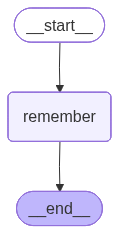

In [7]:

builder = StateGraph(MessagesState)
builder.add_node("remember", remember_only_node)
builder.add_edge(START, "remember")
builder.add_edge("remember", END)

graph = builder.compile(store=store)

graph

In [8]:
# ----------------------------
# 4) Demo
# ----------------------------
config = {"configurable": {"user_id": "u1"}}

res = graph.invoke({"messages": [{"role": "user", "content": "Hi my name is pankaj"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [9]:
res = graph.invoke({"messages": [{"role": "user", "content": "I teach AI on youtube"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [10]:
res = graph.invoke({"messages": [{"role": "user", "content": "My favorite programming language is Python"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [11]:
items = store.search(("user", "u1", "details"))

for item in items:
    print(item.value['data'])

My name is Pankaj
The user teaches AI on YouTube
The user's favorite programming language is Python


In [12]:
res = graph.invoke({"messages": [{"role": "user", "content": "I teach AI on youtube"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [13]:
res = graph.invoke({"messages": [{"role": "user", "content": "My favorite programming language is Python"}]},config)
print("Assistant:", res["messages"][-1].content)

Assistant: Noted.


In [14]:
items = store.search(("user", "u1", "details"))

for item in items:
    print(item.value['data'])

My name is Pankaj
The user teaches AI on YouTube
The user's favorite programming language is Python
The user teaches AI on YouTube
The user's favorite programming language is Python


In [ ]:
# there is problem of duplication